In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import os
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import json
import matplotlib.pyplot as plt
import gc
from tqdm import tqdm

# Constants
NUM_POSE_LANDMARKS = 19   
NUM_HAND_LANDMARKS = 21
NUM_NODES = NUM_POSE_LANDMARKS + NUM_HAND_LANDMARKS*2  # Total nodes in the graph
FEATURE_DIM = 3  # x, y coordinates + visibility

class GCNLayer(nn.Module):
    def __init__(self, in_features, out_features,dropout=0.5):
        super(GCNLayer, self).__init__()
        self.conv = nn.Conv1d(in_features, out_features, kernel_size=1, bias=True)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, adj):
        """x: (batch_size * seq_len, num_nodes, in_features)\n
        adj: (num_nodes, num_nodes) - shared across all samples"""
        
        if adj.device != x.device:
            adj = adj.to(x.device)
            
        # Expand adj to match batch dimension
        batch_size_seq = x.size(0)
        adj_expanded = adj.unsqueeze(0).expand(batch_size_seq, -1, -1)
        
        # Graph convolution: first aggregate neighborhood features
        x = torch.bmm(adj_expanded, x)  # (batch_size * seq_len, num_nodes, in_features)
        
        # For Conv1d: input needs to be (batch, channels, length)
        # So we permute from (batch, nodes, features) to (batch, features, nodes)
        x = x.permute(0, 2, 1)  # -> (batch_size * seq_len, in_features, num_nodes)
        
        # Apply convolution
        x = self.conv(x)  # (batch_size * seq_len, out_features, num_nodes)
        
        # Permute back to original format
        x = x.permute(0, 2, 1)  # -> (batch_size * seq_len, num_nodes, out_features)
        
        x = F.gelu(x)
        x = self.dropout(x)
        return x

class GCNBiLSTM(nn.Module):
    def __init__(self, num_nodes=NUM_NODES, in_features=FEATURE_DIM, 
                 gcn_hidden=64, lstm_hidden=128, num_classes=10, 
                 num_gcn_layers=2, dropout=0.5, label_map=None):
        super(GCNBiLSTM, self).__init__()
        
        # Create multiple GCN layers
        self.gcn_layers = nn.ModuleList()
        self.gcn_layers.append(GCNLayer(in_features, gcn_hidden,dropout))
        
        for _ in range(num_gcn_layers - 1):
            self.gcn_layers.append(GCNLayer(gcn_hidden, gcn_hidden,dropout))
        
        # Bidirectional LSTM layer
        self.lstm = nn.LSTM(
            input_size=num_nodes * gcn_hidden, 
            hidden_size=lstm_hidden, 
            num_layers=2,
            batch_first=True, 
            bidirectional=True,
            dropout=dropout if num_gcn_layers > 1 else 0
        )
        
        # Attention mechanism
        self.attention = nn.Sequential(
            nn.Linear(lstm_hidden * 2, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )
        
        # Output classification layers
        self.classifier = nn.Sequential(
            nn.Linear(lstm_hidden * 2, lstm_hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(lstm_hidden, num_classes)
        )
        
        self.dropout = nn.Dropout(dropout)
        self.label_map = label_map
        self.num_nodes = num_nodes
        self.gcn_hidden = gcn_hidden

    def forward(self, x, adj):
        # x shape: (batch_size, seq_len, num_nodes * in_features)
        # Reshape to (batch_size, seq_len, num_nodes, in_features)
        batch_size, seq_len, _ = x.size()
        x = x.view(batch_size, seq_len, self.num_nodes, -1)
        
        # Process each time step through GCN
        gcn_outputs = []
        for t in range(seq_len):
            # Get current time step data
            curr_x = x[:, t, :, :]  # (batch_size, num_nodes, in_features)
            
            # Process through GCN layers
            for gcn_layer in self.gcn_layers:
                curr_x = gcn_layer(curr_x, adj)
                curr_x = self.dropout(curr_x)
            
            # Flatten node features
            # curr_x = curr_x.view(batch_size, -1)  # (batch_size, num_nodes * gcn_hidden)
            curr_x = curr_x.contiguous().view(batch_size, -1)
            gcn_outputs.append(curr_x)
        
        # Stack outputs to (batch_size, seq_len, num_nodes * gcn_hidden)
        gcn_out = torch.stack(gcn_outputs, dim=1)
        
        # Process through BiLSTM
        lstm_out, _ = self.lstm(gcn_out)  # (batch_size, seq_len, lstm_hidden * 2)
        
        # Apply attention mechanism
        attn_weights = self.attention(lstm_out).squeeze(-1)  # (batch_size, seq_len)
        attn_weights = F.softmax(attn_weights, dim=1).unsqueeze(-1)  # (batch_size, seq_len, 1)
        
        # Weighted sum of LSTM outputs
        context = torch.sum(lstm_out * attn_weights, dim=1)  # (batch_size, lstm_hidden * 2)
        
        # Final classification
        output = self.classifier(context)
        
        return output
    
    def predict_label(self, x, adj):
        self.eval() 
        with torch.no_grad():
            logits = self.forward(x, adj)  # Forward pass
            pred_classes = torch.argmax(logits, dim=1)  # Get the predicted class (index)
            
            if self.label_map is not None:
                pred_labels = [self.label_map[int(idx)] for idx in pred_classes.cpu().numpy()]
                return pred_labels
            else:
                return pred_classes



class GraphSequenceDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = torch.tensor(sequences, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)
        
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]


def parse_frame(frame,):
    keypoints = []
    for part in ['pose', 'left_hand', 'right_hand']:
        for landmark in frame.get(part, []):
            keypoints.extend([landmark['x'], landmark['y'], landmark['visibility']])
    return keypoints


def load_and_preprocess_data(data_dir, sequence_length=15):
    """
    Load and preprocess the JSON files into sequences.
    
    Args:
        data_dir: Directory containing the data
        sequence_length: Number of frames in each sequence
        
    Returns:
        sequences: array of shape (num_sequences, sequence_length, num_nodes * features)
        sequence_labels: array of class labels
        label_encoder: fitted LabelEncoder
    """
    frame_data = []
    raw_labels = []
    
    # Step 1: Collect all labels
    for root, dirs, files in os.walk(data_dir):
        for file in files:
            if file.endswith(".json"):
                label = os.path.basename(os.path.dirname(os.path.join(root, file)))
                raw_labels.append(label)
    
    # Step 2: Fit label encoder
    encoder = LabelEncoder()
    encoder.fit(raw_labels)
    label_map = {label: int(encoder.transform([label])[0]) for label in set(raw_labels)}
    
    sequences = []
    sequence_labels = []

    # Step 3: Parse frames and assign encoded labels
    for root, dirs, files in os.walk(data_dir):
        for file in files:
            if file.endswith(".json"):
                label = os.path.basename(os.path.dirname(os.path.join(root, file)))
                encoded_label = label_map[label]
                with open(os.path.join(root, file), 'r') as f:
                    frames = json.load(f)
                    features=[]
                    for frame in frames:
                        features.append(parse_frame(frame))
                        # frame_data.append([np.array(features), encoded_label])
                    sequences.append(np.stack(features))
                    sequence_labels.append(encoded_label)
    idx_to_label = {v: k for k, v in label_map.items()}
    label_map = idx_to_label
    del idx_to_label
    gc.collect()
    
    return np.array(sequences), np.array(sequence_labels), label_map


def create_adjacency_matrix():
    """Create the adjacency matrix for the graph."""

    pose_connections = [
        # Mouth
        (9,10),
        # Left Eyes
        (1,2),(2,3),(3,7),
        # Right Eyes
        (4,5),(5,6),(6,8),
        # Nose
        (0,4),(0,1),
        # Shoulders
        (11, 12),
        # Connect shoulders to hip
        (11, 17), (12, 18),
        # Connect hip points
        (17, 18),
        # Left arm
        (11, 13), (13, 15),
        # Right arm
        (12, 14), (14, 16)
    ]

    hand_connections = [
        # Thumb
        (0, 1), (1, 2), (2, 3), (3, 4),
        # Index finger
        (0, 5), (5, 6), (6, 7), (7, 8),
        # Middle finger
        (0, 9), (9, 10), (10, 11), (11, 12),
        # Ring finger
        (0, 13), (13, 14), (14, 15), (15, 16),
        # Pinky
        (0, 17), (17, 18), (18, 19), (19, 20),
        # Palm connections
        (5, 9), (9, 13), (13, 17)
    ]
    
    def create_adj_matrix(num_nodes, connections):
        adj_matrix = np.zeros((num_nodes, num_nodes))
        for i, j in connections:
            adj_matrix[i, j] = 1
            adj_matrix[j, i] = 1
        # Add self-loops
        for i in range(num_nodes):
            adj_matrix[i, i] = 1
        return adj_matrix

    pose_adj_matrix = create_adj_matrix(NUM_POSE_LANDMARKS, pose_connections)
    left_hand_adj_matrix = create_adj_matrix(NUM_HAND_LANDMARKS, hand_connections)
    right_hand_adj_matrix = create_adj_matrix(NUM_HAND_LANDMARKS, hand_connections)

    # Calculate the total number of nodes
    total_nodes = NUM_POSE_LANDMARKS + NUM_HAND_LANDMARKS + NUM_HAND_LANDMARKS

    # Initialize a global adjacency matrix
    global_adj_matrix = np.zeros((total_nodes, total_nodes))
    
    # start_pose = NUM_FACE_LANDMARKS
    start_pose=0
    end_pose = start_pose + NUM_POSE_LANDMARKS
    global_adj_matrix[start_pose:end_pose, start_pose:end_pose] = pose_adj_matrix
    
    start_lh = end_pose
    end_lh = start_lh + NUM_HAND_LANDMARKS
    global_adj_matrix[start_lh:end_lh, start_lh:end_lh] = left_hand_adj_matrix
    
    start_rh = end_lh
    end_rh = start_rh + NUM_HAND_LANDMARKS
    global_adj_matrix[start_rh:end_rh, start_rh:end_rh] = right_hand_adj_matrix
    
    # Connect pose to hands
    pose_hand_connections = [
        (start_pose + 15, start_lh),  # Left hand wrist to left hand base
        (start_pose + 16, start_rh),  # Right hand wrist to right hand base
    ]
    for i, j in pose_hand_connections:
        global_adj_matrix[i, j] = 1
        global_adj_matrix[j, i] = 1

    # Normalize adjacency matrix (D^-0.5 * A * D^-0.5)
    # Add identity matrix to include self-connections
    adj_matrix = global_adj_matrix + np.eye(total_nodes)
    
    # Calculate degree matrix
    degree_matrix = np.diag(np.sum(adj_matrix, axis=1))
    
    # D^-0.5
    deg_inv_sqrt = np.linalg.inv(np.sqrt(degree_matrix))
    
    # Normalized adjacency matrix
    normalized_adj_matrix = deg_inv_sqrt @ adj_matrix @ deg_inv_sqrt

    return torch.FloatTensor(normalized_adj_matrix)


def train_model(model, train_loader, val_loader, adj_matrix, num_epochs=50, lr=0.001, 
               weight_decay=1e-5, patience=10, model_save_path='best_model.pt'):
    """
    Train the GCNBiLSTM model
    
    Args:
        model: GCNBiLSTM model
        train_loader: DataLoader for training data
        val_loader: DataLoader for validation data
        adj_matrix: Normalized adjacency matrix
        num_epochs: Number of training epochs
        lr: Learning rate
        weight_decay: Weight decay factor
        patience: Early stopping patience
        model_save_path: Path to save best model
        
    Returns:
        model: Trained model
        train_losses: List of training losses
        val_losses: List of validation losses
        train_accs: List of training accuracies
        val_accs: List of validation accuracies
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    model = model.to(device)
    adj_matrix = adj_matrix.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

    
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    
    best_val_loss = float('inf')
    early_stop_counter = 0
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0
        
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
        for batch_idx, (inputs, targets) in enumerate(progress_bar):
            inputs, targets = inputs.to(device), targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs, adj_matrix)
            
            loss = criterion(outputs, targets)
            loss.backward()
            
            # Optional: gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
            
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            progress_bar.set_postfix({
                'loss': train_loss/(batch_idx+1), 
                'acc': 100.*correct/total
            })
        
        train_loss = train_loss / len(train_loader)
        train_acc = 100. * correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for batch_idx, (inputs, targets) in enumerate(val_loader):
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs, adj_matrix)
                
                loss = criterion(outputs, targets)
                val_loss += loss.item()
                
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()
        
        val_loss = val_loss / len(val_loader)
        val_acc = 100. * correct / total
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        # Update learning rate
        scheduler.step(val_loss)
        
        print(f"Epoch {epoch+1}/{num_epochs} - "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% - "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            # Save only the model state dict
            torch.save({'model_state_dict':model.state_dict(),'label_map':model.label_map}, model_save_path)
            
            
            early_stop_counter = 0
            print(f"Saved best model to {model_save_path}")
        else:
            early_stop_counter += 1
            
        # Early stopping
        if early_stop_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break
    
    # Load best model
    checkpoint = torch.load(model_save_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.label_map = checkpoint['label_map']
    return model, train_losses, val_losses, train_accs, val_accs


def evaluate_model(model, test_loader, adj_matrix):
    """
    Evaluate the model on test data
    
    Args:
        model: Trained GCNBiLSTM model
        test_loader: DataLoader for test data
        adj_matrix: Normalized adjacency matrix
        
    Returns:
        test_acc: Test accuracy
        predictions: Predicted labels
        true_labels: True labels
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    adj_matrix = adj_matrix.to(device)
    
    model.eval()
    correct = 0
    total = 0
    
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs, adj_matrix)
            
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    
    test_acc = 100. * correct / total
    print(f"Test Accuracy: {test_acc:.2f}%")
    
    return test_acc, np.array(all_preds), np.array(all_targets)


def plot_results(train_losses, val_losses, train_accs, val_accs):
    """
    Plot training and validation metrics
    
    Args:
        train_losses: List of training losses
        val_losses: List of validation losses
        train_accs: List of training accuracies
        val_accs: List of validation accuracies
    """
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(val_accs, label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    
    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()


def main():
    torch.serialization.add_safe_globals([LabelEncoder])
    # Set random seeds for reproducibility
    SEED = 42
    torch.manual_seed(SEED)
    np.random.seed(SEED)
    
    # 1. Load and preprocess data
    data_dir = "data"  # Update with your data directory
    test_dir = "test_data"
    sequences, sequence_labels, label_map = load_and_preprocess_data(data_dir)
    
    print(f"Loaded {len(sequences)} sequences with shape {sequences.shape}")
    print(f'Sequence Label {len(sequence_labels)}')
    print(f"Number of classes: {len(label_map)}")
    
    # 2. Create adjacency matrix

    adj_matrix = create_adjacency_matrix()
    print(f'Unique Label : {len(np.unique(sequence_labels))}')
    X_train,X_val,y_train,y_val = train_test_split(
        sequences, sequence_labels, test_size=0.4, random_state=SEED, stratify=sequence_labels
    )
    print(f'Unique Train : {len(np.unique(y_train))}')
    print(f'Unique Val : {len(np.unique(y_val))}')
    X_val,X_test,y_val,y_test = train_test_split(
        X_val, y_val, test_size=0.5, random_state=SEED, stratify=y_val
    )
    print(f'Unique Train : {len(np.unique(y_train))}')
    print(f'Unique Test : {len(np.unique(y_test))}')
    # X_test,y_test, _ = load_and_preprocess_data(test_dir)


    # 4. Create datasets and dataloaders
    train_dataset = GraphSequenceDataset(X_train, y_train)
    val_dataset = GraphSequenceDataset(X_val, y_val)
    test_dataset = GraphSequenceDataset(X_test, y_test)
    
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    # 5. Create and train the model
    num_classes = len(label_map)
    model = GCNBiLSTM(
        num_nodes=NUM_NODES,
        in_features=FEATURE_DIM,
        gcn_hidden=256,
        lstm_hidden=512,
        num_classes=num_classes,
        num_gcn_layers=2,
        dropout=0.3,
        label_map=label_map
    )
    
    # 6. Train the model
    trained_model, train_losses, val_losses, train_accs, val_accs = train_model(
        model, train_loader, val_loader, adj_matrix, 
        num_epochs=100, lr=0.001, weight_decay=5e-4, 
        patience=15, model_save_path='best_gcn_bilstm_model.pt'
    )
    
    # 7. Evaluate the model
    test_acc, predictions, true_labels = evaluate_model(trained_model, test_loader, adj_matrix)
    
    # 8. Plot results
    plot_results(train_losses, val_losses, train_accs, val_accs)
    
    # 9. Print classification report
    
    
    print("\nClassification Report:")
    actual_classes = np.unique(true_labels)
    print(actual_classes)
    class_names = [label_map[int(idx)] for idx in actual_classes]
    print(classification_report(true_labels, predictions, target_names=class_names))
    
    # 10. Plot confusion matrix
    plt.figure(figsize=(12, 10))
    cm = confusion_matrix(true_labels, predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png')
    plt.show()


Loaded 3488 sequences with shape (3488, 3, 183)
Sequence Label 3488
Number of classes: 26
Unique Label : 26
Unique Train : 26
Unique Val : 26
Unique Train : 26
Unique Test : 26
Using device: cuda


Epoch 1/100 [Train]: 100%|██████████| 66/66 [00:21<00:00,  3.01it/s, loss=3.14, acc=5.64]


Epoch 1/100 - Train Loss: 3.1433, Train Acc: 5.64% - Val Loss: 3.0342, Val Acc: 6.88%
Saved best model to best_gcn_bilstm_model.pt


Epoch 2/100 [Train]: 100%|██████████| 66/66 [00:08<00:00,  7.74it/s, loss=3.03, acc=7.22]


Epoch 2/100 - Train Loss: 3.0311, Train Acc: 7.22% - Val Loss: 2.7966, Val Acc: 15.62%
Saved best model to best_gcn_bilstm_model.pt


Epoch 3/100 [Train]: 100%|██████████| 66/66 [00:09<00:00,  6.98it/s, loss=2.68, acc=18.1]


Epoch 3/100 - Train Loss: 2.6755, Train Acc: 18.07% - Val Loss: 2.3261, Val Acc: 23.64%
Saved best model to best_gcn_bilstm_model.pt


Epoch 4/100 [Train]: 100%|██████████| 66/66 [00:07<00:00,  9.14it/s, loss=2.12, acc=32.9]


Epoch 4/100 - Train Loss: 2.1205, Train Acc: 32.93% - Val Loss: 1.9515, Val Acc: 37.54%
Saved best model to best_gcn_bilstm_model.pt


Epoch 5/100 [Train]: 100%|██████████| 66/66 [00:08<00:00,  7.88it/s, loss=1.9, acc=39.2] 


Epoch 5/100 - Train Loss: 1.8994, Train Acc: 39.20% - Val Loss: 1.7319, Val Acc: 46.56%
Saved best model to best_gcn_bilstm_model.pt


Epoch 6/100 [Train]: 100%|██████████| 66/66 [00:09<00:00,  7.19it/s, loss=1.71, acc=43.3]


Epoch 6/100 - Train Loss: 1.7108, Train Acc: 43.26% - Val Loss: 1.6308, Val Acc: 48.14%
Saved best model to best_gcn_bilstm_model.pt


Epoch 7/100 [Train]: 100%|██████████| 66/66 [00:07<00:00,  8.85it/s, loss=1.58, acc=47.1]


Epoch 7/100 - Train Loss: 1.5824, Train Acc: 47.13% - Val Loss: 1.5392, Val Acc: 52.15%
Saved best model to best_gcn_bilstm_model.pt


Epoch 8/100 [Train]: 100%|██████████| 66/66 [00:09<00:00,  7.12it/s, loss=1.49, acc=50.1]


Epoch 8/100 - Train Loss: 1.4923, Train Acc: 50.10% - Val Loss: 1.4274, Val Acc: 54.73%
Saved best model to best_gcn_bilstm_model.pt


Epoch 9/100 [Train]: 100%|██████████| 66/66 [00:06<00:00,  9.74it/s, loss=1.47, acc=50.9]


Epoch 9/100 - Train Loss: 1.4707, Train Acc: 50.86% - Val Loss: 1.4877, Val Acc: 53.30%


Epoch 10/100 [Train]: 100%|██████████| 66/66 [00:06<00:00, 10.31it/s, loss=1.4, acc=51.9] 


Epoch 10/100 - Train Loss: 1.4048, Train Acc: 51.86% - Val Loss: 1.3616, Val Acc: 56.59%
Saved best model to best_gcn_bilstm_model.pt


Epoch 11/100 [Train]: 100%|██████████| 66/66 [00:11<00:00,  5.77it/s, loss=1.34, acc=55.1]


Epoch 11/100 - Train Loss: 1.3359, Train Acc: 55.11% - Val Loss: 1.4042, Val Acc: 54.30%


Epoch 12/100 [Train]: 100%|██████████| 66/66 [00:11<00:00,  5.61it/s, loss=1.3, acc=56.3] 


Epoch 12/100 - Train Loss: 1.3049, Train Acc: 56.31% - Val Loss: 1.3150, Val Acc: 59.03%
Saved best model to best_gcn_bilstm_model.pt


Epoch 13/100 [Train]: 100%|██████████| 66/66 [00:06<00:00, 10.33it/s, loss=1.26, acc=56.9]


Epoch 13/100 - Train Loss: 1.2587, Train Acc: 56.93% - Val Loss: 1.2816, Val Acc: 59.74%
Saved best model to best_gcn_bilstm_model.pt


Epoch 14/100 [Train]: 100%|██████████| 66/66 [00:07<00:00,  9.34it/s, loss=1.18, acc=59.2]


Epoch 14/100 - Train Loss: 1.1805, Train Acc: 59.18% - Val Loss: 1.3319, Val Acc: 58.88%


Epoch 15/100 [Train]: 100%|██████████| 66/66 [00:05<00:00, 11.08it/s, loss=1.14, acc=60.9] 


Epoch 15/100 - Train Loss: 1.1396, Train Acc: 60.90% - Val Loss: 1.3505, Val Acc: 59.31%


Epoch 16/100 [Train]: 100%|██████████| 66/66 [00:03<00:00, 16.74it/s, loss=1.17, acc=59.9]


Epoch 16/100 - Train Loss: 1.1674, Train Acc: 59.94% - Val Loss: 1.2969, Val Acc: 58.02%


Epoch 17/100 [Train]: 100%|██████████| 66/66 [00:03<00:00, 18.72it/s, loss=1.1, acc=62.8] 


Epoch 17/100 - Train Loss: 1.1041, Train Acc: 62.76% - Val Loss: 1.2484, Val Acc: 61.46%
Saved best model to best_gcn_bilstm_model.pt


Epoch 18/100 [Train]: 100%|██████████| 66/66 [00:03<00:00, 19.88it/s, loss=1.09, acc=61.3] 


Epoch 18/100 - Train Loss: 1.0919, Train Acc: 61.28% - Val Loss: 1.2536, Val Acc: 61.75%


Epoch 19/100 [Train]: 100%|██████████| 66/66 [00:03<00:00, 19.47it/s, loss=1.06, acc=64.3] 


Epoch 19/100 - Train Loss: 1.0632, Train Acc: 64.29% - Val Loss: 1.2149, Val Acc: 61.89%
Saved best model to best_gcn_bilstm_model.pt


Epoch 20/100 [Train]: 100%|██████████| 66/66 [00:03<00:00, 18.02it/s, loss=0.997, acc=65.2]


Epoch 20/100 - Train Loss: 0.9974, Train Acc: 65.15% - Val Loss: 1.2009, Val Acc: 63.61%
Saved best model to best_gcn_bilstm_model.pt


Epoch 21/100 [Train]: 100%|██████████| 66/66 [00:03<00:00, 18.17it/s, loss=1, acc=64.7]    


Epoch 21/100 - Train Loss: 1.0026, Train Acc: 64.67% - Val Loss: 1.1083, Val Acc: 65.76%
Saved best model to best_gcn_bilstm_model.pt


Epoch 22/100 [Train]: 100%|██████████| 66/66 [00:03<00:00, 19.96it/s, loss=0.963, acc=66.4]


Epoch 22/100 - Train Loss: 0.9629, Train Acc: 66.40% - Val Loss: 1.1254, Val Acc: 65.19%


Epoch 23/100 [Train]: 100%|██████████| 66/66 [00:03<00:00, 20.21it/s, loss=0.927, acc=67.9]


Epoch 23/100 - Train Loss: 0.9266, Train Acc: 67.93% - Val Loss: 1.1090, Val Acc: 66.91%


Epoch 24/100 [Train]: 100%|██████████| 66/66 [00:03<00:00, 19.87it/s, loss=0.909, acc=68.8]


Epoch 24/100 - Train Loss: 0.9093, Train Acc: 68.79% - Val Loss: 1.1733, Val Acc: 63.04%


Epoch 25/100 [Train]: 100%|██████████| 66/66 [00:03<00:00, 19.51it/s, loss=0.913, acc=67.1]


Epoch 25/100 - Train Loss: 0.9129, Train Acc: 67.11% - Val Loss: 1.0881, Val Acc: 65.04%
Saved best model to best_gcn_bilstm_model.pt


Epoch 26/100 [Train]: 100%|██████████| 66/66 [00:03<00:00, 20.41it/s, loss=0.847, acc=71.1]


Epoch 26/100 - Train Loss: 0.8468, Train Acc: 71.08% - Val Loss: 1.1438, Val Acc: 66.33%


Epoch 27/100 [Train]: 100%|██████████| 66/66 [00:03<00:00, 19.61it/s, loss=0.887, acc=69.7]


Epoch 27/100 - Train Loss: 0.8866, Train Acc: 69.74% - Val Loss: 1.0848, Val Acc: 67.05%
Saved best model to best_gcn_bilstm_model.pt


Epoch 28/100 [Train]: 100%|██████████| 66/66 [00:03<00:00, 20.44it/s, loss=0.832, acc=71.1]


Epoch 28/100 - Train Loss: 0.8324, Train Acc: 71.13% - Val Loss: 1.1144, Val Acc: 66.62%


Epoch 29/100 [Train]: 100%|██████████| 66/66 [00:03<00:00, 20.65it/s, loss=0.834, acc=71]  


Epoch 29/100 - Train Loss: 0.8342, Train Acc: 71.03% - Val Loss: 1.0365, Val Acc: 68.77%
Saved best model to best_gcn_bilstm_model.pt


Epoch 30/100 [Train]: 100%|██████████| 66/66 [00:03<00:00, 20.31it/s, loss=0.779, acc=72.6]


Epoch 30/100 - Train Loss: 0.7790, Train Acc: 72.56% - Val Loss: 1.0236, Val Acc: 69.48%
Saved best model to best_gcn_bilstm_model.pt


Epoch 31/100 [Train]: 100%|██████████| 66/66 [00:03<00:00, 20.04it/s, loss=0.771, acc=72.6]


Epoch 31/100 - Train Loss: 0.7710, Train Acc: 72.56% - Val Loss: 1.1168, Val Acc: 66.76%


Epoch 32/100 [Train]: 100%|██████████| 66/66 [00:03<00:00, 20.61it/s, loss=0.788, acc=72.1]


Epoch 32/100 - Train Loss: 0.7885, Train Acc: 72.13% - Val Loss: 1.0665, Val Acc: 69.34%


Epoch 33/100 [Train]: 100%|██████████| 66/66 [00:03<00:00, 20.67it/s, loss=0.785, acc=72.8]


Epoch 33/100 - Train Loss: 0.7848, Train Acc: 72.85% - Val Loss: 1.0700, Val Acc: 68.48%


Epoch 34/100 [Train]: 100%|██████████| 66/66 [00:03<00:00, 20.17it/s, loss=0.754, acc=73.1]


Epoch 34/100 - Train Loss: 0.7542, Train Acc: 73.09% - Val Loss: 1.0146, Val Acc: 68.91%
Saved best model to best_gcn_bilstm_model.pt


Epoch 35/100 [Train]: 100%|██████████| 66/66 [00:03<00:00, 20.75it/s, loss=0.703, acc=74]  


Epoch 35/100 - Train Loss: 0.7027, Train Acc: 74.00% - Val Loss: 1.0570, Val Acc: 68.48%


Epoch 36/100 [Train]: 100%|██████████| 66/66 [00:03<00:00, 20.63it/s, loss=0.696, acc=73.9]


Epoch 36/100 - Train Loss: 0.6958, Train Acc: 73.95% - Val Loss: 1.0990, Val Acc: 67.62%


Epoch 37/100 [Train]: 100%|██████████| 66/66 [00:03<00:00, 20.29it/s, loss=0.675, acc=75.3]


Epoch 37/100 - Train Loss: 0.6749, Train Acc: 75.33% - Val Loss: 0.9716, Val Acc: 72.06%
Saved best model to best_gcn_bilstm_model.pt


Epoch 38/100 [Train]: 100%|██████████| 66/66 [00:03<00:00, 19.45it/s, loss=0.635, acc=77.9]


Epoch 38/100 - Train Loss: 0.6346, Train Acc: 77.92% - Val Loss: 1.0536, Val Acc: 69.34%


Epoch 39/100 [Train]: 100%|██████████| 66/66 [00:03<00:00, 19.58it/s, loss=0.649, acc=76.2]


Epoch 39/100 - Train Loss: 0.6485, Train Acc: 76.24% - Val Loss: 1.0226, Val Acc: 70.06%


Epoch 40/100 [Train]: 100%|██████████| 66/66 [00:03<00:00, 20.02it/s, loss=0.645, acc=76.4]


Epoch 40/100 - Train Loss: 0.6453, Train Acc: 76.43% - Val Loss: 1.0010, Val Acc: 71.20%


Epoch 41/100 [Train]: 100%|██████████| 66/66 [00:03<00:00, 19.77it/s, loss=0.636, acc=76.5]


Epoch 41/100 - Train Loss: 0.6365, Train Acc: 76.53% - Val Loss: 1.0205, Val Acc: 70.49%


Epoch 42/100 [Train]: 100%|██████████| 66/66 [00:03<00:00, 19.85it/s, loss=0.619, acc=78.1]


Epoch 42/100 - Train Loss: 0.6195, Train Acc: 78.06% - Val Loss: 1.0512, Val Acc: 69.48%


Epoch 43/100 [Train]: 100%|██████████| 66/66 [00:03<00:00, 19.03it/s, loss=0.593, acc=78.5]


Epoch 43/100 - Train Loss: 0.5935, Train Acc: 78.49% - Val Loss: 1.0481, Val Acc: 69.77%


Epoch 44/100 [Train]: 100%|██████████| 66/66 [00:03<00:00, 18.02it/s, loss=0.48, acc=83.1] 


Epoch 44/100 - Train Loss: 0.4797, Train Acc: 83.13% - Val Loss: 1.0150, Val Acc: 71.06%


Epoch 45/100 [Train]: 100%|██████████| 66/66 [00:03<00:00, 18.36it/s, loss=0.446, acc=83.7]


Epoch 45/100 - Train Loss: 0.4461, Train Acc: 83.70% - Val Loss: 1.0408, Val Acc: 71.06%


Epoch 46/100 [Train]: 100%|██████████| 66/66 [00:03<00:00, 17.92it/s, loss=0.399, acc=85.7]


Epoch 46/100 - Train Loss: 0.3985, Train Acc: 85.66% - Val Loss: 1.0342, Val Acc: 70.77%


Epoch 47/100 [Train]: 100%|██████████| 66/66 [00:03<00:00, 19.98it/s, loss=0.4, acc=84.9]  


Epoch 47/100 - Train Loss: 0.4004, Train Acc: 84.94% - Val Loss: 1.0612, Val Acc: 71.63%


Epoch 48/100 [Train]: 100%|██████████| 66/66 [00:03<00:00, 20.42it/s, loss=0.409, acc=84.8]


Epoch 48/100 - Train Loss: 0.4086, Train Acc: 84.80% - Val Loss: 1.0504, Val Acc: 70.34%


Epoch 49/100 [Train]: 100%|██████████| 66/66 [00:03<00:00, 20.74it/s, loss=0.359, acc=87.1]


Epoch 49/100 - Train Loss: 0.3594, Train Acc: 87.09% - Val Loss: 1.0507, Val Acc: 71.35%


Epoch 50/100 [Train]: 100%|██████████| 66/66 [00:03<00:00, 19.94it/s, loss=0.325, acc=89.1]


Epoch 50/100 - Train Loss: 0.3254, Train Acc: 89.05% - Val Loss: 1.0618, Val Acc: 72.64%


Epoch 51/100 [Train]: 100%|██████████| 66/66 [00:03<00:00, 20.74it/s, loss=0.304, acc=88.9]


Epoch 51/100 - Train Loss: 0.3044, Train Acc: 88.86% - Val Loss: 1.0853, Val Acc: 70.20%


Epoch 52/100 [Train]: 100%|██████████| 66/66 [00:03<00:00, 20.47it/s, loss=0.298, acc=89.2]


Epoch 52/100 - Train Loss: 0.2982, Train Acc: 89.20% - Val Loss: 1.0573, Val Acc: 73.21%
Early stopping triggered after 52 epochs
Test Accuracy: 65.33%


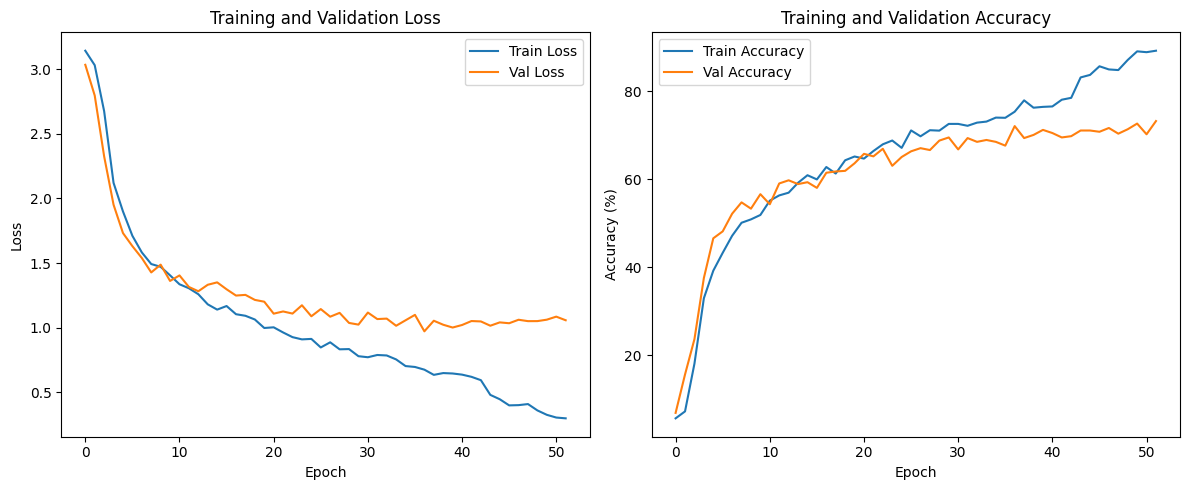


Classification Report:
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
              precision    recall  f1-score   support

           A       0.62      0.50      0.56        20
           B       0.63      0.52      0.57        23
           C       0.49      0.68      0.57        28
           D       0.47      0.40      0.43        20
           E       0.81      0.81      0.81        26
           F       0.46      0.46      0.46        24
           G       0.75      0.72      0.74        29
           H       0.59      0.64      0.62        25
           I       0.88      0.93      0.90        30
           J       0.81      0.87      0.84        30
           K       0.61      0.56      0.58        25
           L       0.68      0.85      0.75        27
           M       0.57      0.26      0.36        31
           N       0.53      0.84      0.65        32
           O       0.70      0.77      0.73        30
           P       0.48      0

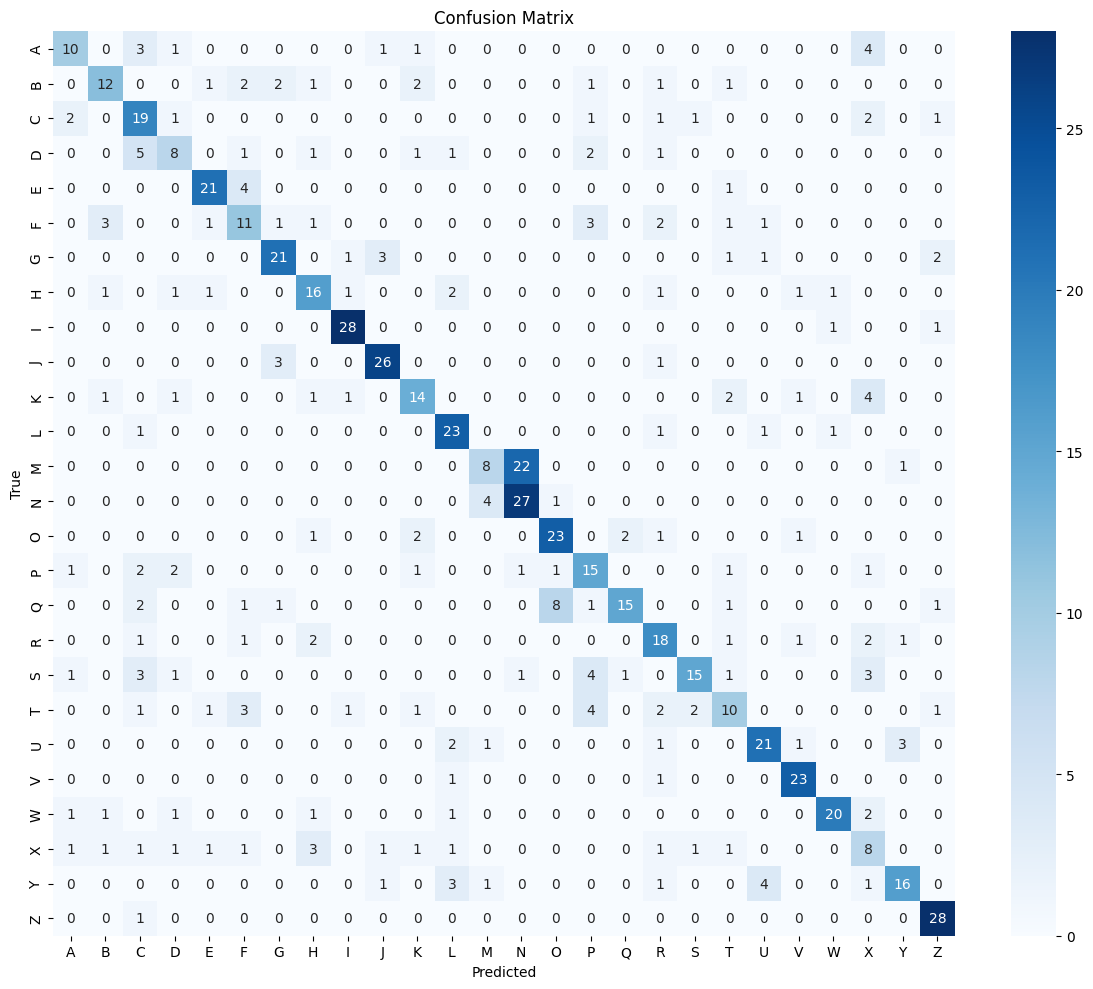

In [4]:
main()